<a href="https://colab.research.google.com/github/mking2014/final-4449-king/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

Examples: https://www.kaggle.com/code/uzzivirus/age-and-gender-detection#Normalizing-data

https://www.hackersrealm.net/post/gender-and-age-prediction-using-python#google_vignette

In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/')

# Load Data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/comp4449_final/content 2/data/age_gender.csv')
df = df.drop(columns = ['img_name'])
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (23705, 4)


,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [8]:
# Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [9]:
df['pixels'][0].shape

(2304,)

Gender: Male = 0, Female = 1


# EDA

In [10]:
gender_dict = {0 : "Male", 1: "Female"}
ethnicity_dict = {0: "Caucasian", 1: "Black", 2: "Asian", 3:"Indian", 4:"Hispanic"}

Text(0, 0.5, 'Count')

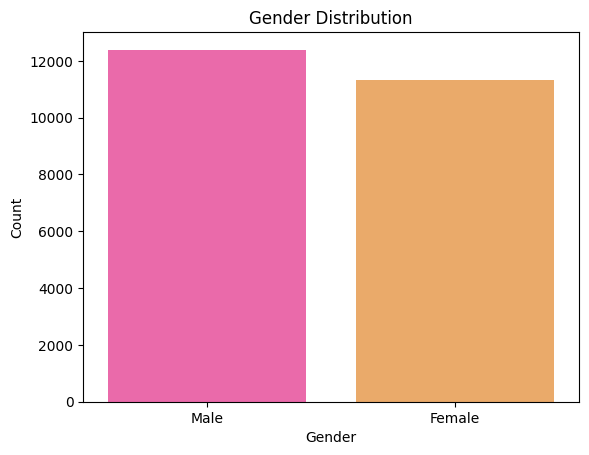

In [11]:
sns.countplot(data=df.replace({"gender" : gender_dict}), x="gender", palette='spring')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

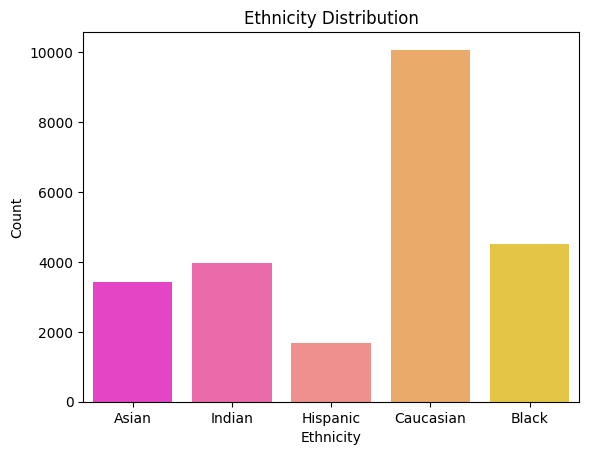

In [12]:
sns.countplot(x="ethnicity", palette='spring',
              data=df.replace({"ethnicity" : ethnicity_dict}))

plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')

Text(0.5, 0, 'Age')

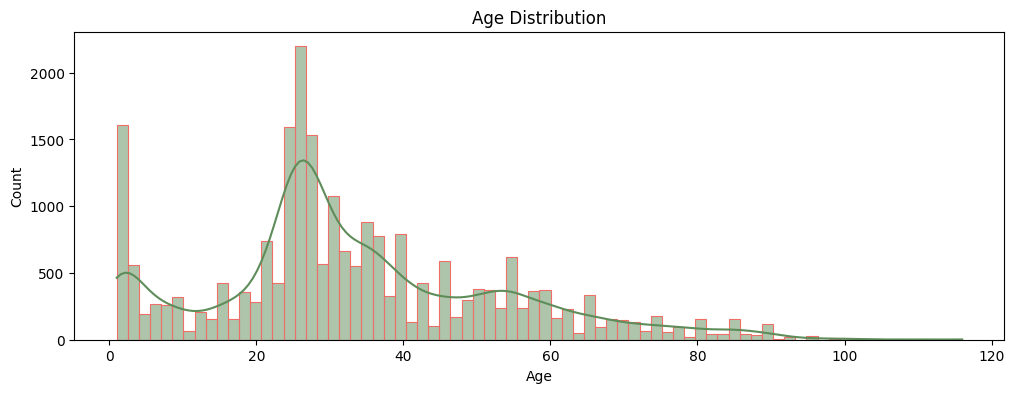

In [13]:
plt.figure(figsize=(12, 4))

sns.histplot(data = df, x='age', color = '#5e8d5a', edgecolor='#ee6f68', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')

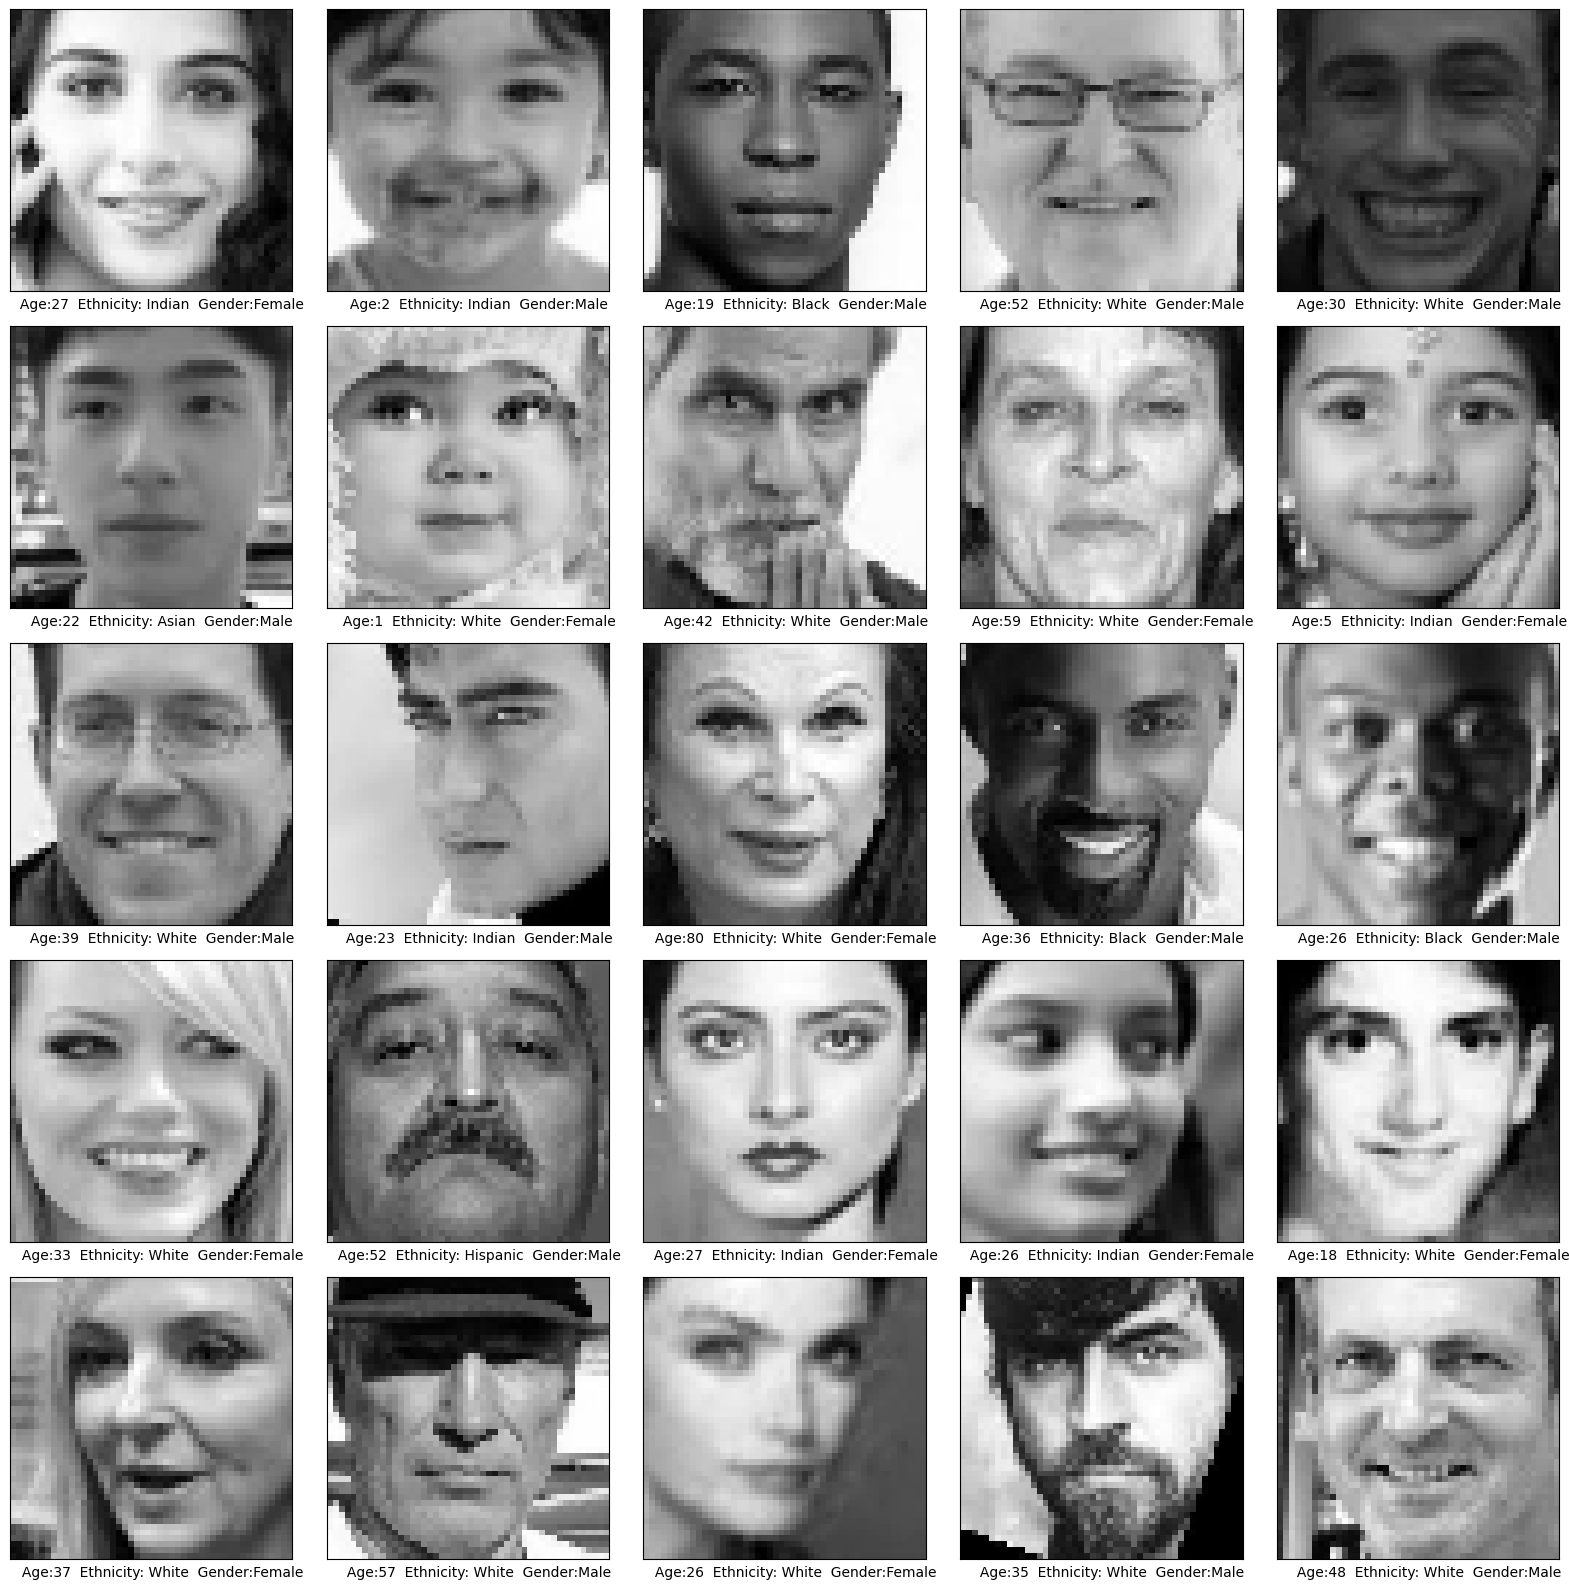

In [14]:
ethnicity_list = ["White", "Black", "Asian", "Indian", "Hispanic"]
gender_list = ['Male', 'Female']

plt.figure(figsize=(16,16))

for i,a in zip(np.random.randint(0, 23705, 25),range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48, 48), cmap ='gray')
    plt.xlabel(
        "     Age:"+str(df['age'].iloc[i])+
        "  Ethnicity: "+ str(ethnicity_list[df['ethnicity'].iloc[i]])+
        "  Gender:"+ str(gender_list[df['gender'].iloc[i]])
    )

plt.tight_layout()
plt.show()

# Data Preparation

This model will predict the age & gender usge the images. A classification model will be used to predict the gender (binary result) while a regression model will be used to predict the age.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df = df.drop(columns = ['ethnicity'])

In [17]:
test, train = train_test_split(df, test_size=0.85, random_state=42)
print(train.shape)
print(test.shape)

(20150, 3)
(3555, 3)


In [18]:
train.head()

,age,gender,pixels
17814,49,1,"[31.0, 32.0, 28.0, 27.0, 34.0, 38.0, 37.0, 40...."
15080,39,0,"[186.0, 65.0, 38.0, 40.0, 36.0, 51.0, 64.0, 64..."
22829,8,0,"[20.0, 23.0, 35.0, 34.0, 45.0, 65.0, 69.0, 72...."
16074,40,0,"[6.0, 6.0, 13.0, 19.0, 15.0, 23.0, 41.0, 76.0,..."
8972,27,0,"[31.0, 31.0, 29.0, 51.0, 98.0, 136.0, 162.0, 1..."


In [19]:
X_train = train['pixels']
# normalizing pixels data
X_train = X_train/255

# reshape images
X_train = np.array(X_train.tolist())
X_train = X_train.reshape(-1,48,48, 1)
print(f"Shape of images: {X_train.shape}")

y_train_age = train['age']
y_train_gender = train['gender']
print(f"Age array shape: {(y_train_age.shape)}")
print(f"Gender array shape: {(y_train_gender.shape)}")

Shape of images: (20150, 48, 48, 1)
Age array shape: (20150,)
Gender array shape: (20150,)


In [20]:
X_test = test['pixels']
# normalizing pixels data
X_test = X_test/255

# reshape images
X_test = np.array(X_test.tolist())
X_test = X_test.reshape(-1,48,48, 1)
print(f"Shape of images: {X_test.shape}")

y_test_age = test['age']
y_test_gender = test['gender']
print(f"Age array shape: {(y_test_age.shape)}")
print(f"Gender array shape: {(y_test_gender.shape)}")

Shape of images: (3555, 48, 48, 1)
Age array shape: (3555,)
Gender array shape: (3555,)


In [21]:
input_shape = (48, 48, 1)

# Model Development

In [22]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, RandomFlip, RandomRotation, RandomContrast, BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from math import sqrt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, accuracy_score

In [23]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

### Gender Model

In [ ]:
def create_gender_model(img_input_shape):
  model =  Sequential([
      Conv2D(32, (3,3), activation='relu', input_shape=(img_input_shape)),
      MaxPooling2D((2,2)),

      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D((2,2)),

      Conv2D(128, (3,3), activation='relu'),
      MaxPooling2D((2,2)),

      Flatten(),

      Dropout(0.5),

      Dense(1, activation='sigmoid')
  ])
  return model

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 4)
history = model.fit(x = X_train, y = y_train_gender, batch_size = 32, epochs = 100,
                    validation_split = 0.2, callbacks =[tensorboard_callback, early_stopping])

Epoch 1/100
89/89 [==============================] - 9s 15ms/step - loss: 1.5695 - gender_out_loss: 0.6908 - age_out_loss: 0.8787 - gender_out_accuracy: 0.5239 - age_out_accuracy: 0.5658 - val_loss: 1.3387 - val_gender_out_loss: 0.6770 - val_age_out_loss: 0.6617 - val_gender_out_accuracy: 0.6540 - val_age_out_accuracy: 0.6245
Epoch 2/100
89/89 [==============================] - 1s 12ms/step - loss: 1.2788 - gender_out_loss: 0.6236 - age_out_loss: 0.6551 - gender_out_accuracy: 0.6793 - age_out_accuracy: 0.6663 - val_loss: 1.1976 - val_gender_out_loss: 0.5971 - val_age_out_loss: 0.6004 - val_gender_out_accuracy: 0.6906 - val_age_out_accuracy: 0.7032
Epoch 3/100
89/89 [==============================] - 1s 11ms/step - loss: 1.1391 - gender_out_loss: 0.5539 - age_out_loss: 0.5852 - gender_out_accuracy: 0.7247 - age_out_accuracy: 0.7071 - val_loss: 1.0246 - val_gender_out_loss: 0.5072 - val_age_out_loss: 0.5174 - val_gender_out_accuracy: 0.7511 - val_age_out_accuracy: 0.7539
Epoch 4/100
89/8

# Single Model

In [162]:
inputs = Input((input_shape))

# augmentation layers
aug = RandomFlip(mode = 'horizontal', seed = 27)(inputs)
aug = RandomRotation(factor = 0.1, fill_mode='nearest', seed = 27)(aug)
aug = RandomContrast(factor = 0.1, seed = 27)(aug)

# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (aug)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)

BatchNormalization()

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

# conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
# maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)


flat = Flatten() (maxp_3)

# age model
# age_model = Dropout(0.5)(flat)
age_model = Dense(256, activation = 'relu')(flat)
age_model = Dropout(0.5)(age_model)
age_model = Dense(128, activation = 'relu')(age_model)
# age_model = Dropout(0.5)(age_model)
# age_model = Dense(64, activation = 'relu')(age_model)
# age_model = Dropout(0.5)(age_model)
# age_model = Dense(32, activation = 'relu')(age_model)
# age_model = Dropout(0.5)(age_model)
# age_model = Dense(16, activation = 'relu')(age_model)
# age_model = Dropout(0.5)(age_model)
# age_model = Dense(8, activation = 'relu')(age_model)
# age_model = Dropout(0.5)(age_model)
age_model = Dense(1, activation = 'relu', name = 'age_out')(age_model)

# gender model
# gender_model = Dropout(0.5)(flat)
gender_model = Dense(256, activation = 'relu')(flat)
gender_model = Dropout(0.5)(gender_model)
gender_model = Dense(128, activation = 'relu')(gender_model)
# gender_model = Dropout(0.5)(gender_model)
# gender_model = Dense(64, activation = 'relu')(gender_model)
# gender_model = Dropout(0.5)(gender_model)
# gender_model = Dense(32, activation = 'relu')(gender_model)
# gender_model = Dropout(0.5)(gender_model)
gender_model = Dense(1, activation = 'sigmoid', name = 'gender_out')(gender_model)


model = Model(inputs=[inputs], outputs=[gender_model, age_model])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [163]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 random_flip_11 (RandomFlip  (None, 48, 48, 1)            0         ['input_14[0][0]']            
 )                                                                                                
                                                                                                  
 random_rotation_11 (Random  (None, 48, 48, 1)            0         ['random_flip_11[0][0]']      
 Rotation)                                                                                        
                                                                                           

In [164]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='val_loss', patience = 4)

In [165]:
history = model.fit(x=X_train, y=[y_train_gender, y_train_age], batch_size=32,
                    epochs=100, validation_split=0.2, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/100
504/504 [==============================] - 8s 9ms/step - loss: 16.2103 - gender_out_loss: 0.6968 - age_out_loss: 15.5135 - gender_out_accuracy: 0.5131 - age_out_accuracy: 0.0470 - val_loss: 14.6291 - val_gender_out_loss: 0.6917 - val_age_out_loss: 13.9374 - val_gender_out_accuracy: 0.5067 - val_age_out_accuracy: 0.0486
Epoch 2/100
504/504 [==============================] - 4s 8ms/step - loss: 14.4407 - gender_out_loss: 0.6429 - age_out_loss: 13.7979 - gender_out_accuracy: 0.6109 - age_out_accuracy: 0.0473 - val_loss: 12.8020 - val_gender_out_loss: 0.5456 - val_age_out_loss: 12.2565 - val_gender_out_accuracy: 0.7380 - val_age_out_accuracy: 0.0486
Epoch 3/100
504/504 [==============================] - 4s 8ms/step - loss: 13.3179 - gender_out_loss: 0.5694 - age_out_loss: 12.7485 - gender_out_accuracy: 0.7010 - age_out_accuracy: 0.0473 - val_loss: 13.8124 - val_gender_out_loss: 0.5394 - val_age_out_loss: 13.2730 - val_gender_out_accuracy: 0.7476 - val_age_out_accuracy: 0.0486
E

In [64]:
model.save('/content/models/5')

In [35]:
# from tensorboard import notebook
# notebook.list()
# # load tensorboard
# # notebook.display(port=6006, height=1000)
# %load_ext tensorboard
# %tensorboard --logdir logs

### Model Evaluation

In [38]:
## returns in (age, gender)

def get_model_results(model, data):
  '''
  IN: Model, model you would like to predict your results from
  Data: DataFrame, Dataset you'd like ot predict results from
  '''


  predictions = []
  labels = []

  data = data.values.tolist()

  for x in data:

    labels.append((x[0], x[1]))

    m_pred = model.predict(x[2].reshape(-1, 48, 48, 1), verbose = 0)

    predictions.append((round(m_pred[1][0][0]), round(m_pred[0][0][0])))

  return labels, predictions

def evaluate_classification_model(g_labels, g_preds):

  cm = confusion_matrix(g_labels, g_preds)
  sns.heatmap(cm, annot = True, fmt ='.0f', xticklabels = ['Male', 'Female'], yticklabels=['Male', 'Female'])
  plt.ylabel('True Label')
  plt.xlabel('Predictied Label')
  plt.title('Gender Classficiation')
  print(f"Accuracy: {accuracy_score(g_labels, g_preds)}")
  print(f"Precision: {precision_score(g_labels, g_preds)}")
  print(f"Recall: {recall_score(g_labels, g_preds)}")
  print(f"F1 Score: {f1_score(g_labels, g_preds)}")

  return

def evaluate_regression_model(a_labels, a_preds):
  plt.scatter(x = a_labels, y = a_preds)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title('Actual vs Predicted Ages')
  print(f"RMSE: {sqrt(mean_squared_error(a_labels, a_preds))}")
  print(f"MAE: {mean_absolute_error(a_labels, a_preds)}")

In [166]:
%%time
actual, preds = get_model_results(model, test[:500])

CPU times: user 25.3 s, sys: 1.1 s, total: 26.4 s
Wall time: 25.5 s


In [167]:
age_labels = [x[0] for x in actual]
age_preds = [x[0] for x in preds]

gender_labels = [x[1] for x in actual]
gender_preds = [x[1] for x in preds]

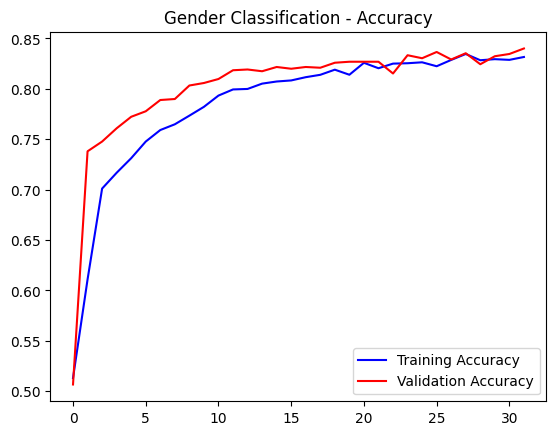

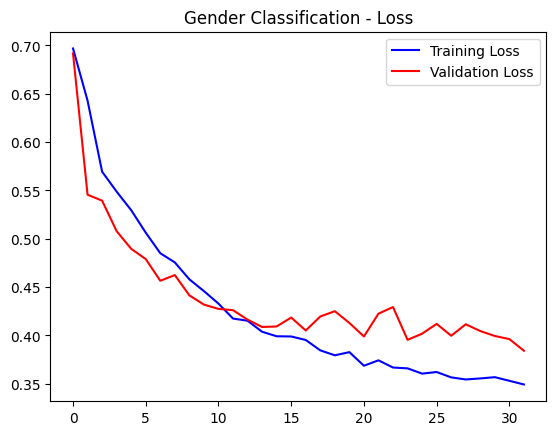

In [168]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Classification - Accuracy')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Classification - Loss')
plt.legend()
plt.show()

Accuracy: 0.718
Precision: 0.6919831223628692
Recall: 0.7068965517241379
F1 Score: 0.6993603411513859


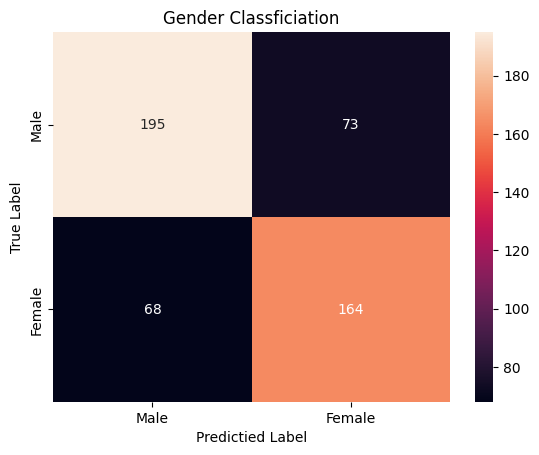

In [169]:
evaluate_classification_model(gender_labels, gender_preds)

In [ ]:
# Current architecture works the best for gender classification so far

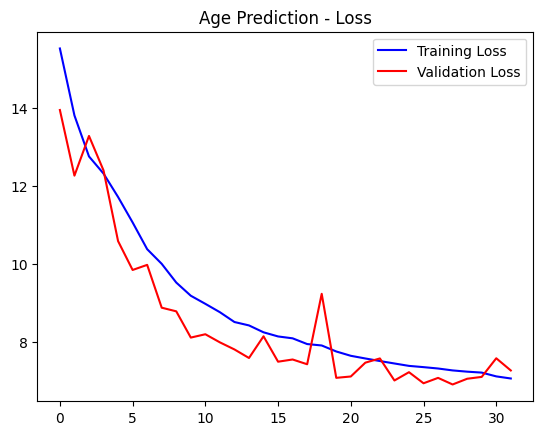

In [170]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Age Prediction - Loss')
plt.legend()
plt.show()

RMSE: 686.805844471347
MAE: 570.536


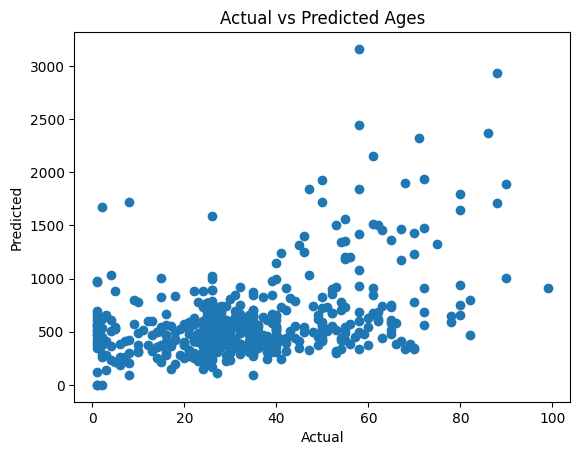

In [171]:
evaluate_regression_model(age_labels, age_preds)

In [ ]:
# SDG optimization works best for age, does not work well with gender

### Model Predictions

In [179]:
def make_prediction(age, gender, pixels):

  gender_dict = {0:'Male', 1:'Female'}

  print(f"Actual age: {age}")
  print(f"Actual gender {gender_dict[gender]}")

  m_prediction = model.predict(pixels.reshape(-1,48,48, 1))

  print(f"Predicted age: {round(m_prediction[1][0][0])}")
  print(f"Predicted gender: {gender_dict[round(m_prediction[0][0][0])]}")


  return m_prediction

pred = test.sample()
prediction = make_prediction(pred.values[0][0], pred.values[0][1], pred.values[0][2])

Actual age: 42
Actual gender Male
1/1 [==============================] - 0s 19ms/step
Predicted age: 2004
Predicted gender: Male
